In [1]:
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from sklearn.preprocessing import LabelEncoder
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn import metrics

In [2]:
# import data and create graphs
df = pd.read_csv('/home/aytonks2/all_graph_update_lag_weather_nn_top_weather_lag_dev_3.csv', engine='python')

data_list = []

# process by day
for DAY, group in df.groupby('DAY'):
    NODELABEL = LabelEncoder().fit_transform(group.TRAPID)
    node_labels = group.loc[group.DAY==DAY,['NODELABEL','TRAPID']].sort_values('NODELABEL').TRAPID.drop_duplicates().values
    edges_to = [[int(x) for x in s.split(", ")] if type(s) is str else [] for s in group.EDGES]
    edges_from = []
    for i in range(len(edges_to)):
        # self-loop
        edges_to[i].insert(0, group.NODELABEL.values[i])
        edges_from.append([group.NODELABEL.values[i]]*len(edges_to[i]))
    edges_to = [item for sublist in edges_to for item in sublist]
    edges_from = [item for sublist in edges_from for item in sublist]
    
    x0 = torch.FloatTensor(group.DailyCoolingDegreeDays.values)
    x1 = torch.FloatTensor(group.DailyHeatingDegreeDays.values)
    x2 = torch.FloatTensor(group.DailyPrecipitation.values)
    x3 = torch.FloatTensor(group.WEEK_POS_0.values)
    
    x4 = torch.FloatTensor(group.DailyCoolingDegreeDays7.values)
    x5 = torch.FloatTensor(group.DailyHeatingDegreeDays7.values)
    x6 = torch.FloatTensor(group.DailyPrecipitation7.values)
    x7 = torch.FloatTensor(group.WEEK_POS_7.values)
    
    x8 = torch.FloatTensor(group.DailyCoolingDegreeDays14.values)
    x9 = torch.FloatTensor(group.DailyHeatingDegreeDays14.values)
    x10 = torch.FloatTensor(group.DailyPrecipitation14.values)
    x11 = torch.FloatTensor(group.WEEK_POS_14.values)
        
    x12 = torch.FloatTensor(group.DailyCoolingDegreeDays21.values)
    x13 = torch.FloatTensor(group.DailyHeatingDegreeDays21.values)
    x14 = torch.FloatTensor(group.DailyPrecipitation21.values)
    x15 = torch.FloatTensor(group.WEEK_POS_21.values)
        
    x16 = torch.FloatTensor(group.DailyCoolingDegreeDays28.values)
    x17 = torch.FloatTensor(group.DailyHeatingDegreeDays28.values)
    x18 = torch.FloatTensor(group.DailyPrecipitation28.values)
    x19 = torch.FloatTensor(group.WEEK_POS_28.values)
        
    x20 = torch.FloatTensor(group.DailyCoolingDegreeDays35.values)
    x21 = torch.FloatTensor(group.DailyHeatingDegreeDays35.values)
    x22 = torch.FloatTensor(group.DailyPrecipitation35.values)
    x23 = torch.FloatTensor(group.WEEK_POS_35.values)
        
    x24 = torch.FloatTensor(group.DailyCoolingDegreeDays42.values)
    x25 = torch.FloatTensor(group.DailyHeatingDegreeDays42.values)
    x26 = torch.FloatTensor(group.DailyPrecipitation42.values)
    x27 = torch.FloatTensor(group.WEEK_POS_42.values)
    
    x = torch.stack((x0, x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11, x12, x13, x14, x15,
                    x16, x17, x18, x19, x20, x21, x22, x23, x24, x25, x26, x27), dim=1)
    y = torch.FloatTensor(group.NEXTWKPOS.values)
    edge_index = torch.tensor([edges_from, edges_to], dtype=torch.long)
    
    data = Data(x=x, y=y, edge_index=edge_index)
    data_list.append(data)

n_features = x.shape[1]

In [3]:
# 2008 - 2016 (8.5 years)
train_data_loader = DataLoader(data_list[0:1258], batch_size=100)
# 2017 - 2018 (2 years)
valid_data_loader = DataLoader(data_list[1258:1502], batch_size=100)
# 2019 - 2021 (2.5 years)
test_data_loader = DataLoader(data_list[1502:1764], batch_size=100)

In [4]:
# define logistic, FC and GNN models
class Net(torch.nn.Module):
    def __init__(self, lag_wks, mod_type):
        super(Net, self).__init__()
        self.lag_wks = lag_wks
        self.cols = range(self.lag_wks*4-4, self.lag_wks*4)
        self.mod_type = mod_type
        if self.mod_type=="Logistic":
            self.lin1 = torch.nn.Linear(len(self.cols), 1)
        elif self.mod_type=="Fully-connected":
            self.lin1 = torch.nn.Linear(len(self.cols), 8)
            self.lin2 = torch.nn.Linear(8, 8)
            self.lin3 = torch.nn.Linear(8, 8)
            self.lin4 = torch.nn.Linear(8, 1)
        elif self.mod_type=="GNN":
            self.conv1 = SAGEConv(len(self.cols), 8)
            self.conv2 = SAGEConv(8, 8)
            self.conv3 = SAGEConv(8, 8)
            self.conv4 = SAGEConv(8, 1)
        else:
            print("No such model type")
    def forward(self, data):        
        x, edge_index = data.x[:, self.cols], data.edge_index
        if self.mod_type=="Logistic":
            x = self.lin1(x)
        elif self.mod_type=="Fully-connected":
            x = self.lin1(x)
            x = F.relu(x)
            x = self.lin2(x)
            x = F.relu(x)
            x = self.lin3(x)
            x = F.relu(x)
            x = self.lin4(x)
        elif self.mod_type=="GNN":
            x = self.conv1(x, edge_index)
            x = F.relu(x)
            x = self.conv2(x, edge_index)
            x = F.relu(x)
            x = self.conv3(x, edge_index)
            x = F.relu(x)
            x = self.conv4(x, edge_index)
        return x

In [5]:
device = torch.device('cuda')

def train(model, loader, crit, optimizer):
    loss_tot = 0.0
    dataset_len = 0
    for data in loader:
        data = data.to(device)
        log_odds_dev = torch.squeeze(model(data))
        loss = crit(log_odds_dev, data.y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_tot += loss.item()*len(data.y)
        dataset_len += len(data.y)
    return loss_tot/dataset_len

In [6]:
def calc_loss(model, loader, crit):
    model.eval()
    loss_tot = 0.0
    dataset_len = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            log_odds_dev = torch.squeeze(model(data))
            loss = crit(log_odds_dev, data.y)
            loss_tot += loss.item()*len(data.y)
            dataset_len += len(data.y)
    return loss_tot/dataset_len

In [7]:
# create loss plot using lists of loss values
def plot_loss(n_epochs, train_loss, valid_loss, title):
    plt.plot(list(range(n_epochs)), train_loss, label="Train loss")
    plt.plot(list(range(n_epochs)), valid_loss, color='r', label="Validation loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend(loc="upper right")
    plt.show()

In [ ]:
# compute predicted probabilities and classes for pytorch models
def nn_comp_preds(model, loader):
    probabilities = []
    predictions = []
    labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            log_odds_dev = torch.squeeze(model(data))
            probs = torch.sigmoid(log_odds_dev.detach()).cpu().numpy()
            pred = np.int32(probs>0.5)
            label = np.int32(data.y.detach().cpu().numpy())
            probabilities.extend(probs)
            predictions.extend(pred)
            labels.extend(label)
    return labels, probabilities, predictions

In [8]:
# calculate metrics using lists of true labels and predicted probabilities/classes
def calc_metrics(labels, probabilities, predictions):
    roc = metrics.roc_curve(labels, probabilities)
    plt.plot(roc[0], roc[1])
    plt.show()
    
    metric_names = ["Accuracy", "Precision", "Recall", "F1", "Brier score", "AUC"]
    metric_vals = [metrics.accuracy_score(labels, predictions)] \
    + list(metrics.precision_recall_fscore_support(labels, predictions, pos_label=1, average="binary")[:3]) \
    + [metrics.brier_score_loss(labels, probabilities), metrics.roc_auc_score(labels, probabilities)]
    metrics_dict = dict(zip(metric_names, metric_vals))
    
    return metrics_dict

In [9]:
# run one of the pytorch models at a given lag and return metrics
def run_nn_mod(lag_wks, mod_type, n_epochs):
    model = Net(lag_wks, mod_type).to(device)
    crit = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    model.train()
    train_loss = []
    valid_loss = []
    for epoch in tqdm(range(n_epochs)):
        train_loss.append(train(model, train_data_loader, crit, optimizer))
        valid_loss.append(calc_loss(model, valid_data_loader, crit))
    
    title = mod_type + " model loss (" + str(lag_wks) + " week forecast distance)" \
        if lag_wks==1 else \
        mod_type + " model loss (" + str(lag_wks) + " weeks forecast distance)"
    plot_loss(n_epochs, train_loss, valid_loss, title)
    
    labels, probabilities, predictions = nn_comp_preds(model, test_data_loader)
    metrics_dict = {"Model type":mod_type, "Forecast distance (weeks)":lag_wks}
    metrics_dict.update(calc_metrics(labels, probabilities, predictions))
    return  metrics_dict, labels, probabilities

In [ ]:
# prepare data for use with xgboost function
from xgboost import XGBClassifier

xg_boost_cols = ["DailyCoolingDegreeDays", "DailyHeatingDegreeDays", "DailyPrecipitation", "WEEK_POS_0",
                 "DailyCoolingDegreeDays7", "DailyHeatingDegreeDays7", "DailyPrecipitation7", "WEEK_POS_7",
                 "DailyCoolingDegreeDays14", "DailyHeatingDegreeDays14", "DailyPrecipitation14", "WEEK_POS_14",
                 "DailyCoolingDegreeDays21", "DailyHeatingDegreeDays21", "DailyPrecipitation21", "WEEK_POS_21",
                 "DailyCoolingDegreeDays28", "DailyHeatingDegreeDays28", "DailyPrecipitation28", "WEEK_POS_28",
                 "DailyCoolingDegreeDays35", "DailyHeatingDegreeDays35", "DailyPrecipitation35", "WEEK_POS_35",
                 "DailyCoolingDegreeDays42", "DailyHeatingDegreeDays42", "DailyPrecipitation42", "WEEK_POS_42",
                 "NEXTWKPOS"]

# 2008 - 2016 (8.5 years)
xg_boost_df_train = df.loc[0:54426, xg_boost_cols]
# 2017 - 2018 (2 years)
xg_boost_df_valid = df.loc[54426:67473, xg_boost_cols]
# 2019 - 2021 (2.5 years)
xg_boost_df_test = df.loc[67473:81481, xg_boost_cols]

In [10]:
# run xgboost model with data at a given lag and return metrics
def run_xgboost_mod(lag_wks):
    cols = range(lag_wks*4-4, lag_wks*4)

    model = XGBClassifier(use_label_encoder=False)
    model.fit(xg_boost_df_train.iloc[:, cols], xg_boost_df_train.iloc[:, 28],
              eval_set=[(xg_boost_df_valid.iloc[:, cols], xg_boost_df_valid.iloc[:, 28])],
              early_stopping_rounds=50, eval_metric="logloss", verbose=0)
    
    labels = xg_boost_df_test.iloc[:, 28].tolist()
    probabilities = model.predict_proba(xg_boost_df_test.iloc[:, cols])[:, 1].tolist()
    predictions = [round(x) for x in probabilities]

    metrics_dict = {"Model type":"XGboost", "Forecast distance (weeks)":lag_wks}
    metrics_dict.update(calc_metrics(labels, probabilities, predictions))
    
    return metrics_dict, labels, probabilities

100%|██████████| 500/500 [00:22<00:00, 21.96it/s]


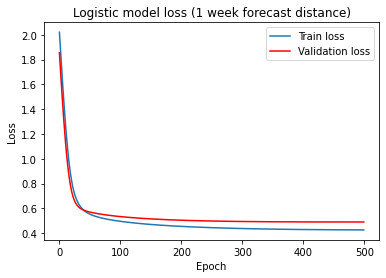

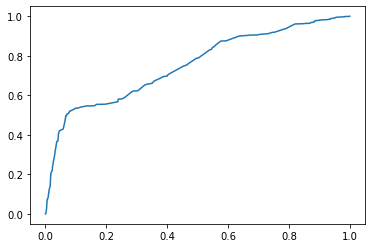

100%|██████████| 500/500 [00:22<00:00, 21.95it/s]


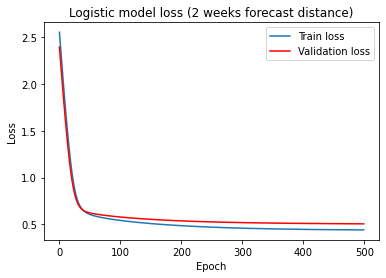

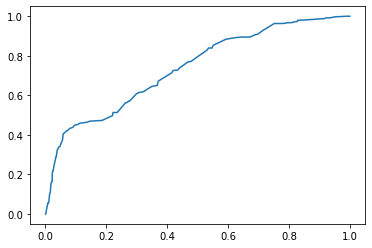

100%|██████████| 500/500 [00:23<00:00, 21.49it/s]


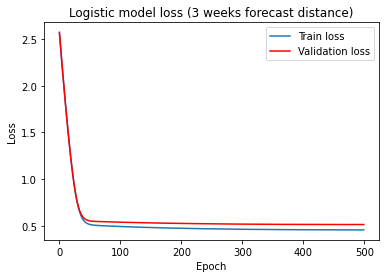

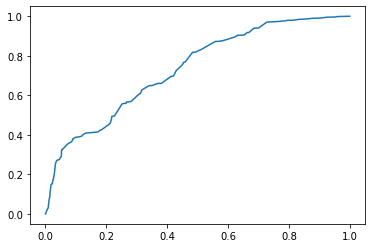

100%|██████████| 500/500 [00:23<00:00, 20.86it/s]


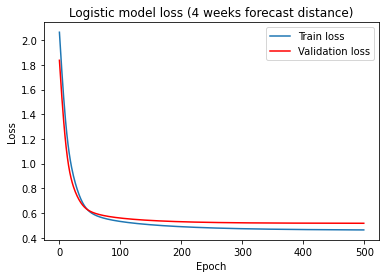

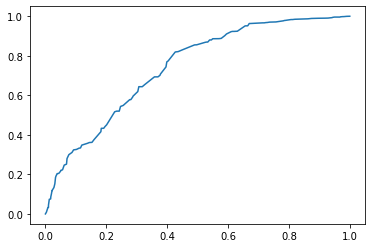

/home/aytonks2/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 500/500 [00:22<00:00, 22.41it/s]


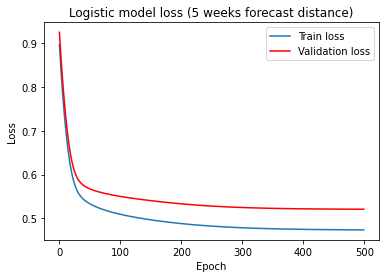

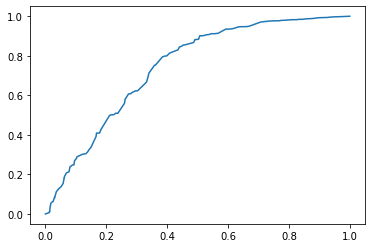

/home/aytonks2/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 500/500 [00:22<00:00, 22.49it/s]


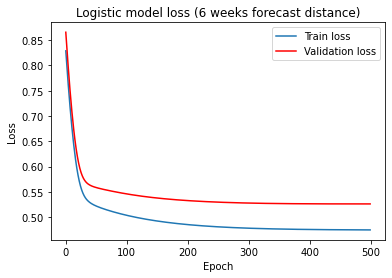

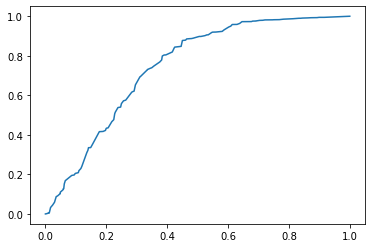

/home/aytonks2/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 500/500 [00:23<00:00, 21.14it/s]


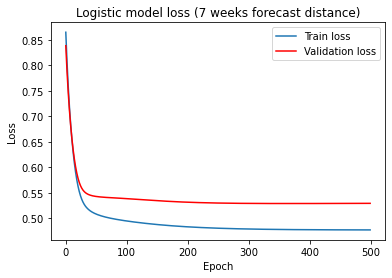

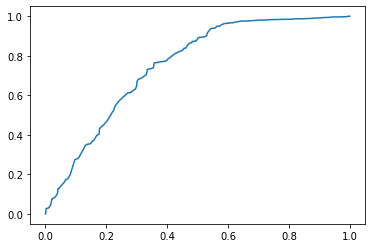

/home/aytonks2/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 500/500 [00:27<00:00, 18.36it/s]


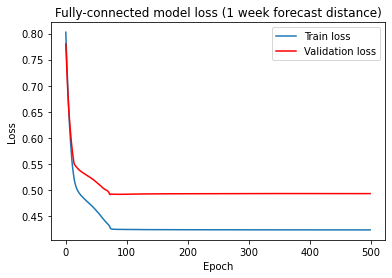

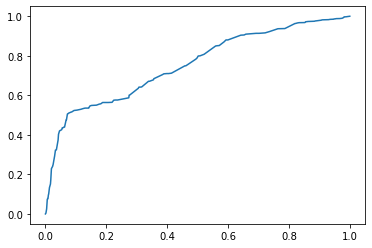

100%|██████████| 500/500 [00:26<00:00, 18.89it/s]


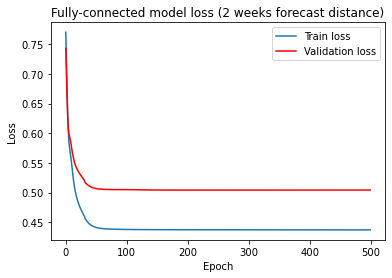

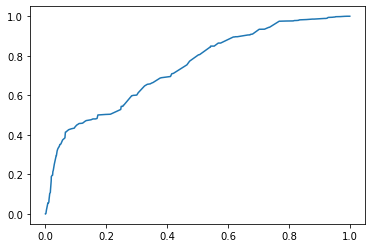

100%|██████████| 500/500 [00:29<00:00, 17.22it/s]


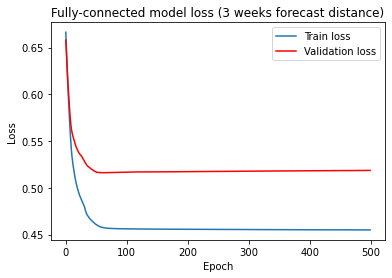

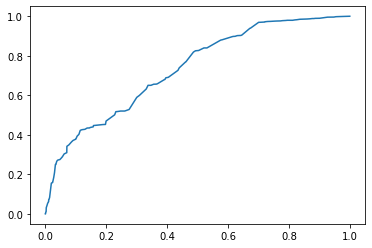

100%|██████████| 500/500 [00:27<00:00, 17.89it/s]


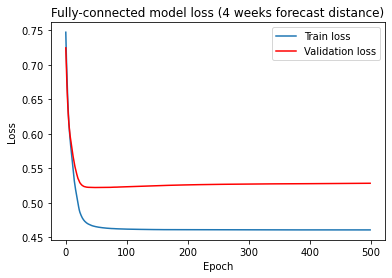

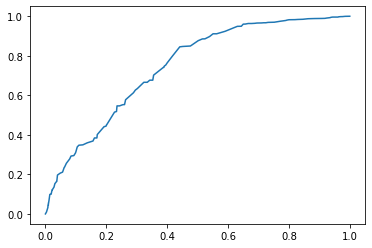

100%|██████████| 500/500 [00:29<00:00, 16.74it/s]


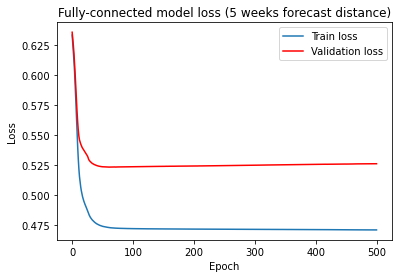

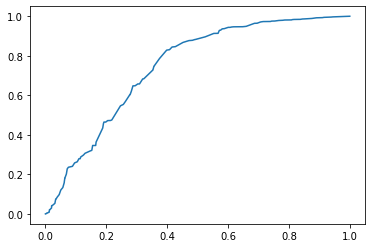

/home/aytonks2/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 500/500 [00:30<00:00, 16.41it/s]


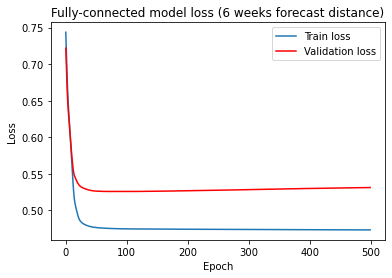

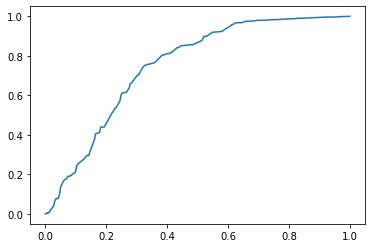

/home/aytonks2/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 500/500 [00:29<00:00, 16.73it/s]


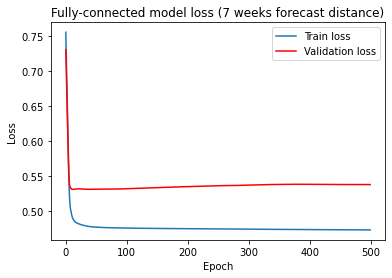

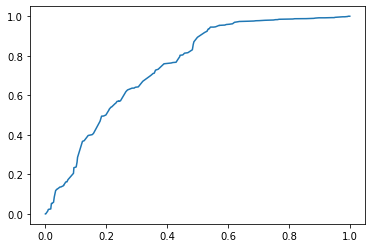

/home/aytonks2/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 500/500 [00:40<00:00, 12.48it/s]


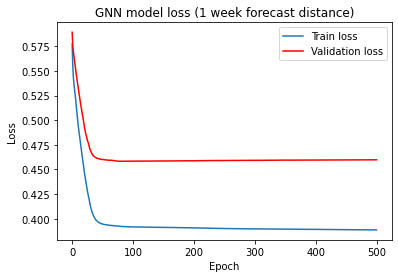

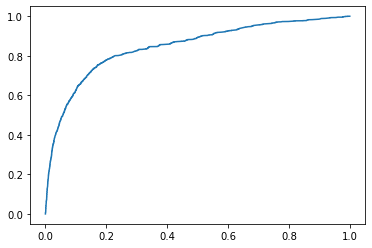

100%|██████████| 500/500 [00:41<00:00, 12.00it/s]


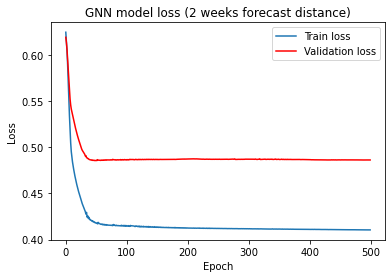

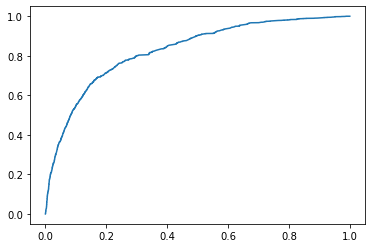

100%|██████████| 500/500 [00:42<00:00, 11.86it/s]


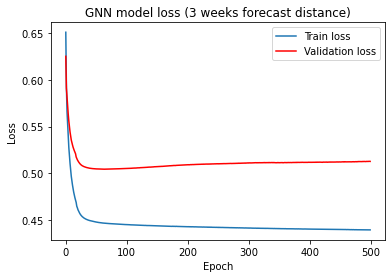

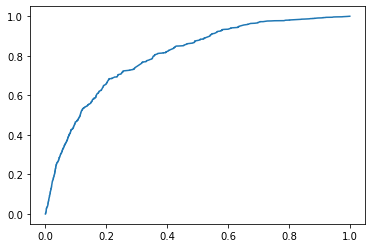

100%|██████████| 500/500 [00:39<00:00, 12.60it/s]


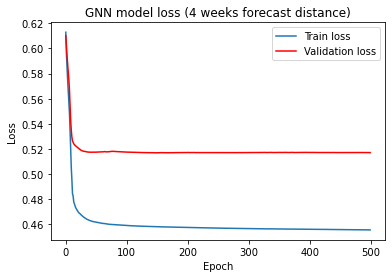

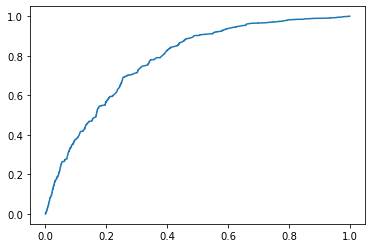

100%|██████████| 500/500 [00:40<00:00, 12.33it/s]


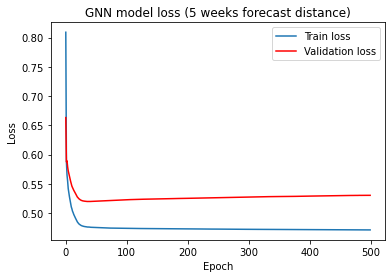

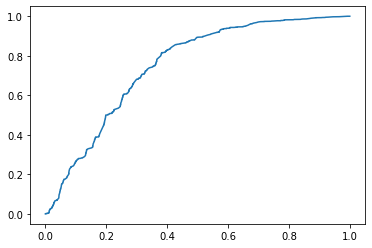

100%|██████████| 500/500 [00:39<00:00, 12.51it/s]


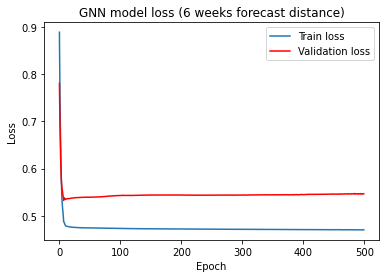

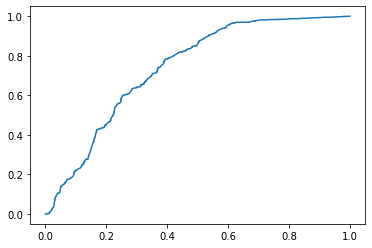

/home/aytonks2/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 500/500 [00:40<00:00, 12.37it/s]


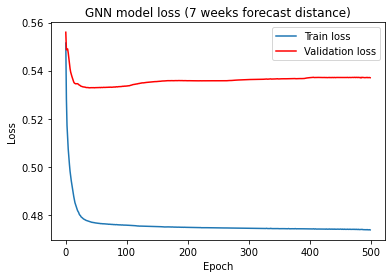

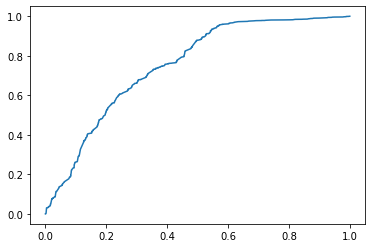

/home/aytonks2/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [11]:
# loop to run the pytorch models at different lags
n_epochs = 500
dict_lst = []
labels_lst = []
probs_lst = []
for mod_type in ["Logistic", "Fully-connected", "GNN"]:
    for lag_wks in range(1, 8):
        metrics_dict, labels, probabilities = run_nn_mod(lag_wks, mod_type, n_epochs)
        dict_lst.append(metrics_dict)
        labels_lst.append(labels)
        probs_lst.append(probabilities)

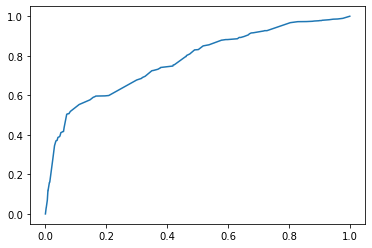

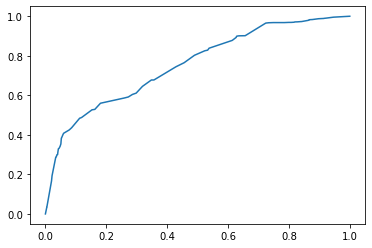

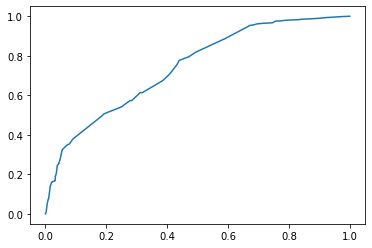

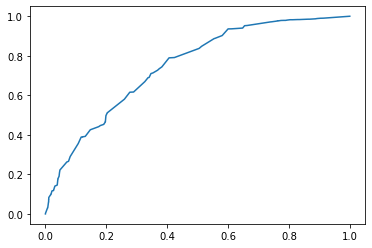

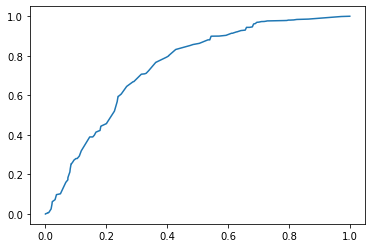

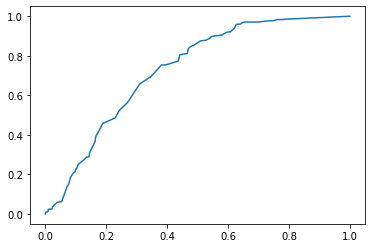

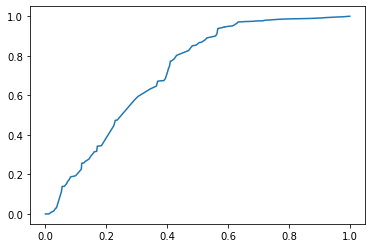

In [12]:
# loop to run xgboost model at various lags
for lag_wks in range(1, 8):
    metrics_dict, labels, probabilities = run_xgboost_mod(lag_wks)
    dict_lst.append(metrics_dict)
    labels_lst.append(labels)
    probs_lst.append(probabilities)

In [13]:
# create the dataframe of metrics and save it
results_df = pd.DataFrame(dict_lst)
results_df.to_csv("results_table_all.csv", index=False)
results_df

,Model type,Forecast distance (weeks),Accuracy,Precision,Recall,F1,Brier score,AUC
0,Logistic,1,0.868861,0.622568,0.371747,0.465522,0.105620,0.752377
1,Logistic,2,0.859223,0.619681,0.216543,0.320937,0.113230,0.737688
2,Logistic,3,0.844160,0.400000,0.028810,0.053749,0.117368,0.732548
3,Logistic,4,0.846374,0.000000,0.000000,0.000000,0.120729,0.740089
4,Logistic,5,0.846374,0.000000,0.000000,0.000000,0.121099,0.743045
5,Logistic,6,0.846374,0.000000,0.000000,0.000000,0.119627,0.744303
6,Logistic,7,0.846374,0.000000,0.000000,0.000000,0.118672,0.751213
7,Fully-connected,1,0.868575,0.619707,0.374071,0.466531,0.104950,0.753367
8,Fully-connected,2,0.861151,0.597366,0.295074,0.395023,0.112653,0.741570
9,Fully-connected,3,0.848444,0.572139,0.053439,0.097748,0.117255,0.734355


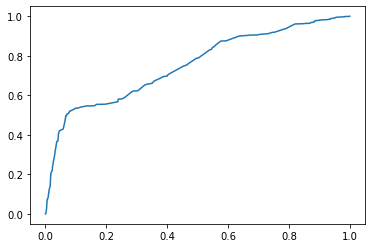

In [14]:
# example of replotting ROC curve from stored labels and predicted probabilities
roc = metrics.roc_curve(labels_lst[0], probs_lst[0])
plt.plot(roc[0], roc[1])
plt.show()